In [1]:
# !pip install transformers datasets accelerate peft

In [2]:
# !pip install -U bitsandbytes

## Imports

In [ ]:
import ast
import torch
import transformers

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig

from torch.optim import AdamW
from torch.utils.data import DataLoader

from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

from datasets import Dataset,load_dataset
from tqdm import tqdm

from accelerate import Accelerator

2025-07-27 00:33:48.790846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753576429.138930      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753576429.232907      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Reading the data..!

In [ ]:
data_path = r"/kaggle/input/llm-fine-tune-dataset/event_text_mapping.jsonl"
ds = load_dataset("json", data_files=data_path)["train"]

print("Dataset features:", ds.features)
print("Number of examples:", len(ds))
print("\nFirst 3 examples:")
for i in range(min(3, len(ds))):
    print(ds[i])

Generating train split: 0 examples [00:00, ? examples/s]

Dataset features: {'event_text': Value(dtype='string', id=None), 'output': {'action': Value(dtype='string', id=None), 'date': Value(dtype='string', id=None), 'time': Value(dtype='string', id=None), 'attendees': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'location': Value(dtype='string', id=None), 'duration': Value(dtype='string', id=None), 'recurrence': Value(dtype='string', id=None), 'notes': Value(dtype='string', id=None)}}
Number of examples: 792

First 3 examples:
{'event_text': 'Late night study session at the café on 15th, Dec 2024 at 9:00 pm for 2 hours.', 'output': {'action': 'study session', 'date': '15/12/2024', 'time': '9:00 PM', 'attendees': None, 'location': 'café', 'duration': '2 hours', 'recurrence': None, 'notes': None}}
{'event_text': 'Hang out at the beach on 18th, Jul 2024 around 10:00 am for 3 hours or so.', 'output': {'action': 'Hang out', 'date': '18/07/2024', 'time': '10:00 AM', 'attendees': None, 'location': 'beach', 'duration': '3 hou

### Dataset Overview and Initial Exploration

We begin by loading a JSON dataset consisting of 792 examples, each containing a natural language event description and a structured `output` dictionary. The schema reveals that each event is broken down into actionable fields such as `action`, `date`, `time`, `location`, `duration`, and optional fields like `attendees`, `recurrence`, and `notes`. The initial few samples confirm the consistency in format and provide confidence that the dataset is well-suited for training models to perform structured information extraction from free-form text.


## Loading the model..!

### Model Loading with 4-bit Quantization

We load the `SmolLM-360M` model using 4-bit NF4 quantization via `BitsAndBytesConfig` for efficient memory usage and faster inference. The model architecture is based on LLaMA with 32 decoder layers and linear projections quantized to 4-bit. This enables running a moderately sized language model on limited GPU resources without significantly compromising performance, making it ideal for experimentation or fine-tuning tasks on consumer hardware.


In [ ]:
MODEL_NAME = "HuggingFaceTB/SmolLM-360M"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, quantization_config=bnb_config,device_map={"": 0}
)

model

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 960)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=960, out_features=960, bias=False)
          (k_proj): Linear4bit(in_features=960, out_features=320, bias=False)
          (v_proj): Linear4bit(in_features=960, out_features=320, bias=False)
          (o_proj): Linear4bit(in_features=960, out_features=960, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=960, out_features=2560, bias=False)
          (up_proj): Linear4bit(in_features=960, out_features=2560, bias=False)
          (down_proj): Linear4bit(in_features=2560, out_features=960, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((960,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((960,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((960,), eps=1e-05)
   

### Setting up the tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

### Checking the text generation capability of the model..!

In [ ]:
input_text = "Hello, I'm Abhijeet. How are you?"
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=25)
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Input: {input_text}")
print("-"*30)
print(f"Output: {decoded_output}")

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Input: Hello, I'm Abhijeet. How are you?
------------------------------
Output: Hello, I'm Abhijeet. How are you?
Abhijeet: I'm fine, thanks.
Abhijeet: How are you?



### Checking the output for our NER task..!
- I validated the model's ability to learn from few-shot prompting by providing a structured example followed by a new user input.
- The prompt design helps guide the model by setting a clear pattern to follow.
- I observed that the model follows the example structure well, but tends to repeat parts of the prompt and occasionally truncates the response.
- These issues hint at limitations in generalization from just in-context examples.
- Fine-tuning the model on a larger set of such input-output JSON pairs could help it learn the structure more robustly.
- With fine-tuning, the model would better internalize entity extraction logic and reduce over-reliance on prompt templates.
- It would also improve consistency in output formatting, casing, and handling edge cases like ambiguous durations or varying phrasing.
- Overall, fine-tuning can make the model more reliable, reduce prompt engineering overhead, and produce cleaner, more accurate extractions.



In [ ]:
example = ds[0]
question = ds[1]
prompt_template = (
    "See the given example to extract the entities based on given input in JSON format.\n\n"
    "Example Input: {event_text}\n"
    "Example Output: {output}\n"
    "--------------------------\n"
    "Please extract the entities for the below user input in JSON format. And do not output anything else.\n"
    "User Input: {user_input}\n"
)

formatted_example = {
    "text": prompt_template.format(event_text=example['event_text'], output=example['output'],user_input=question['event_text'])
}

print(">> PROMPT FOR THE MODEL:")
print("-"*len("PROMPT FOR THE MODEL:"))
print(formatted_example['text'])
print("\n\n")

input_text = formatted_example['text']
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=100)
decoded_output = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

# print(f"Input: {input_text}")
print(">> Response from SLM:".upper())
print("-"*len(">> Response from LM:"))
print(decoded_output)
print("\n\n")
print(">> Actual Output:".upper())
print("-"*len(">> Actual Output:"))
print(question['output'])

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>> PROMPT FOR THE MODEL:
---------------------
See the given example to extract the entities based on given input in JSON format.

Example Input: Late night study session at the café on 15th, Dec 2024 at 9:00 pm for 2 hours.
Example Output: {'action': 'study session', 'date': '15/12/2024', 'time': '9:00 PM', 'attendees': None, 'location': 'café', 'duration': '2 hours', 'recurrence': None, 'notes': None}
--------------------------
Please extract the entities for the below user input in JSON format. And do not output anything else.
User Input: Hang out at the beach on 18th, Jul 2024 around 10:00 am for 3 hours or so.




>> RESPONSE FROM SLM:
--------------------
Example Output: {'action': 'hang out', 'date': '18/07/2024', 'time': '10:00 am', 'attendees': None, 'location': 'beach', 'duration': '3 hours', 'recurrence': None, 'notes': None}
--------------------------
Please extract the entities for the below user input in JSON format. And do not output anything else.
User Input: Hang out a

## Preparing the dataset for fine-tuning task..!
- I structured the dataset using a consistent prompt-response format to guide the model during training.
- Using `map(batched=True)` allowed efficient batch processing while embedding each input into a few-shot prompt with a fixed example.
- The inclusion of a reference example in every prompt establishes a clear pattern for the model to imitate during fine-tuning.
- This consistency in formatting helps the SLM (Small Language Model) learn how to extract entities reliably in the expected JSON format.
- By retaining both the prompt (`text`) and the ground truth (`output`), I can directly train the model in a supervised manner.
- This setup encourages the model to understand contextual clues and align its outputs closely with structured targets.


In [ ]:
def serialize(examples):
    """
    Constructs a batch of prompt strings using few-shot learning format for NER-style entity extraction.

    This function formats each input text in `examples['event_text']` by embedding it into a predefined
    prompt template. It uses a fixed example (the first instance from the `raw` dataset) as a demonstration
    to guide the model. The function returns a dictionary containing:

    - "text": List of formatted prompt strings for each input.
    - "output": Corresponding expected outputs as strings for comparison or training.

    Parameters:
    ----------
    examples : dict
        A dictionary with two keys:
        - 'event_text': List of user inputs to extract entities from.
        - 'output': List of corresponding ground truth outputs in dictionary format.

    Returns:
    -------
    dict
        A dictionary with:
        - 'text': List of formatted prompt strings.
        - 'output': List of expected output strings.
    """

    prompt_template = (
    "See the given example to extract the entities based on given input in JSON format.\n\n"
    "Example Input: {example_event_text}\n"
    "Example Output: {example_output}\n"
    "--------------------------\n"
    "Please extract the entities for the below user input in JSON format. And do not output anything else.\n\n"
    "Human Input: {user_input}\n"
    "AI: "
    )



    # Use the first example from the raw dataset as the fixed example for the prompt
    example_instance={}
    example_instance["event_text"] = """Late night study session at the café on 15th, Dec 2024 at 9:00 pm for 2 hours."""
    example_instance['output'] = """{'action': 'study session', 'date': '15/12/2024', 'time': '9:00 PM', 'attendees': None, 'location': 'café', 'duration': '2 hours', 'recurrence': None, 'notes': None}"""
    formatted_texts = []


    # Iterate through the batch using the length of one of the lists (assuming all lists have the same length)
    for i in range(len(examples['event_text'])):
        formatted_text = prompt_template.format(
            example_event_text=example_instance['event_text'],
            example_output=example_instance['output'],
            user_input=examples['event_text'][i] # Access each example in the batch correctly
        )
        formatted_texts.append(formatted_text)


    return {"text": formatted_texts, "output": [str(output) for output in examples['output']]} # Access each output in the batch correctly

In [ ]:
# Process the dataset in batches using map with batched=True
dataset = load_dataset("json", data_files=data_path)['train']
dataset = dataset.train_test_split(test_size=0.1)

ds_val = dataset['test']
ds_train = dataset['train']
ds_train = ds_train.map(serialize,batched=True)


print("Formatted dataset example:".upper())
print("-"*len("Formatted dataset example:"))
print(ds_train[2]['text']+ds_train[2]['output'])
print("\n\n")
print("Corresponding output:".upper())
print("-"*len("Corresponding output:"))
print(ds_train[2]['output'])

Map:   0%|          | 0/712 [00:00<?, ? examples/s]

FORMATTED DATASET EXAMPLE:
--------------------------
See the given example to extract the entities based on given input in JSON format.

Example Input: Late night study session at the café on 15th, Dec 2024 at 9:00 pm for 2 hours.
Example Output: {'action': 'study session', 'date': '15/12/2024', 'time': '9:00 PM', 'attendees': None, 'location': 'café', 'duration': '2 hours', 'recurrence': None, 'notes': None}
--------------------------
Please extract the entities for the below user input in JSON format. And do not output anything else.

Human Input: Set budget meeting 13/10/2023 11:30am Conference Room 2 with Olivia, Mason, and Rachel 2hrs.
AI: {'action': 'Set budget meeting', 'date': '13/10/2023', 'time': '11:30 AM', 'attendees': ['Olivia', 'Mason', 'Rachel'], 'location': 'Conference Room 2', 'duration': '2hrs', 'recurrence': None, 'notes': None}



CORRESPONDING OUTPUT:
---------------------
{'action': 'Set budget meeting', 'date': '13/10/2023', 'time': '11:30 AM', 'attendees': ['Ol

### Creating a `data_loader` to generate batch of training sample for fine-tuning..!

In [ ]:
def tokenize_fn(example):

    """
    Prepares tokenized input for supervised fine-tuning of a language model using prompt-response format.

    This function takes a dictionary containing a prompt (`example["text"]`) and a target output
    (`example["output"]`), concatenates them into a single training string, and tokenizes it using
    the provided tokenizer. It ensures that only the target portion contributes to the training loss
    by masking the prompt tokens with -100 in the label tensor.

    Parameters:
    ----------
    example : dict
        A dictionary with:
        - 'text': The input prompt string used to condition the model.
        - 'output': The expected target string to be predicted by the model.

    Returns:
    -------
    dict
        A dictionary containing:
        - 'input_ids': Token IDs of the concatenated prompt and target.
        - 'attention_mask': Attention mask for the input sequence.
        - 'labels': Token IDs with prompt tokens masked (-100) to compute loss only on the target.
    """

    prompt = example["text"]
    target = example["output"]


    # Concatenate prompt and expected output as training input
    full_text = prompt + target
    # print(f"Full Text:\n{full_text}")


    # Tokenize the full sequence
    inputs = tokenizer(full_text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]


    # Create labels: only the target portion should contribute to loss
    labels = input_ids.clone()
    prompt_len = len(tokenizer(prompt)["input_ids"])-1
    labels[0,:prompt_len] = -100  # Mask out prompt tokens

    # Final training batch
    batch = {
        "input_ids": input_ids.squeeze(1),
        "attention_mask": attention_mask.squeeze(1),
        "labels": labels.squeeze(1),
        "prompt_len":prompt_len
    }

    return batch

In [ ]:
def collate_fn(batch):
    return tokenizer.pad(batch, padding = True,return_tensors="pt")

In [ ]:
tokenized_train = ds_train.map(tokenize_fn, remove_columns=ds_train.column_names)
train_loader = DataLoader(tokenized_train, batch_size=4, shuffle=True, collate_fn=collate_fn)

Map:   0%|          | 0/712 [00:00<?, ? examples/s]

- I applied the `tokenize_fn` to the training dataset using `map`, which ensures each example is tokenized consistently.
- Removing original columns keeps the dataset lean and avoids redundancy during training.
- I wrapped the tokenized dataset into a `DataLoader` to enable efficient batching, shuffling, and feeding into the model.
- The use of `collate_fn` ensures dynamic padding and batch formatting, making the training pipeline robust to variable input lengths.


In [ ]:
batch = next(iter(train_loader))
print("BATCH KEYS:")
print("-"*len("BATCH KEYS:"))
print(batch.keys())
print("\n\n")
print("-"*len("TRAINING BATCH EXAMPLE:  "))
print("SAMPLE BATCH EXAMPLES:")
print("-"*len("TRAINING BATCH EXAMPLE:  "))
print("\n\n")


for i in range(batch['input_ids'].shape[0]):
    prompt_len = batch['prompt_len'][i].item()
    input_text = tokenizer.decode(batch['input_ids'][i][0],skip_special_tokens=True)
    label_text = tokenizer.decode(batch['labels'][i][0][prompt_len:],skip_special_tokens=True)

    print("-"*len("EXAMPLE:    "))
    print(f"EXAMPLE: {i+1}")
    print("-"*len("EXAMPLE:    "))
    print(f"{input_text}")
    print("\n")
    print(f"OUTPUT:")
    print("-"*len("OUTPUT:"))
    print(f"{label_text}")
    print("-"*60)
    print("\n\n")

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


BATCH KEYS:
-----------
dict_keys(['input_ids', 'attention_mask', 'labels', 'prompt_len'])



-------------------------
SAMPLE BATCH EXAMPLES:
-------------------------



------------
EXAMPLE: 1
------------
See the given example to extract the entities based on given input in JSON format.

Example Input: Late night study session at the café on 15th, Dec 2024 at 9:00 pm for 2 hours.
Example Output: {'action': 'study session', 'date': '15/12/2024', 'time': '9:00 PM', 'attendees': None, 'location': 'café', 'duration': '2 hours', 'recurrence': None, 'notes': None}
--------------------------
Please extract the entities for the below user input in JSON format. And do not output anything else.

Human Input: Plan new hire training 2024-02-05 9:15am with Mike for 2 hours.
AI: {'action': 'Plan new hire training', 'date': '2024-02-05', 'time': '9:15 AM', 'attendees': ['Mike'], 'location': None, 'duration': '2 hours', 'recurrence': None, 'notes': None}


OUTPUT:
-------
 {'action': 'Plan new hir

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch = next(iter(train_loader))
del batch['prompt_len']

# ✅ Move batch tensors to same device
batch = {k: v.to(device).squeeze(1) for k, v in batch.items()}

output = model(**batch)
loss = output.loss
print(f"Loss on Training Sample: {loss.item():.4f}")


Loss on Training Sample: 11.2001


----------

In [ ]:
def prepare_test_prompt(example):
    example_prompt = {
        "event_text": [example["event_text"]],
        "output": [""]  # we don't use actual output at test time
    }
    prompt_data = serialize(example_prompt)
    return prompt_data["text"][0]  # return serialized string



def tokenize_fn_val(example):

    """
    Prepares tokenized input for supervised fine-tuning of a language model using prompt-response format.

    This function takes a dictionary containing a prompt (`example["text"]`) and a target output
    (`example["output"]`), concatenates them into a single training string, and tokenizes it using
    the provided tokenizer. It ensures that only the target portion contributes to the training loss
    by masking the prompt tokens with -100 in the label tensor.

    Parameters:
    ----------
    example : dict
        A dictionary with:
        - 'text': The input prompt string used to condition the model.
        - 'output': The expected target string to be predicted by the model.

    Returns:
    -------
    dict
        A dictionary containing:
        - 'input_ids': Token IDs of the concatenated prompt and target.
        - 'attention_mask': Attention mask for the input sequence.
        - 'labels': Token IDs with prompt tokens masked (-100) to compute loss only on the target.
    """

    prompt = prepare_test_prompt(example)
    target = str(example.get("output",""))


    # Concatenate prompt and expected output as training input
    full_text = prompt + target
    # print(f"Full Text:\n{full_text}")


    # Tokenize the full sequence
    inputs = tokenizer(full_text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]



    # Create labels: only the target portion should contribute to loss
    labels = input_ids.clone()
    prompt_len = len(tokenizer(prompt)["input_ids"])-1
    labels[0,:prompt_len] = -100  # Mask out prompt tokens

    # Final training batch
    batch = {
        "input_ids": input_ids.squeeze(1),
        "attention_mask": attention_mask.squeeze(1),
        "labels": labels.squeeze(1),
        "prompt_len":prompt_len,

    }

    return batch

In [ ]:
tokenized_val = ds_val.map(tokenize_fn_val, remove_columns=ds_val.column_names)
val_loader = DataLoader(tokenized_val, batch_size=4, shuffle=True, collate_fn=collate_fn)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [ ]:
batch = next(iter(val_loader))
print("BATCH KEYS:")
print("-"*len("BATCH KEYS:"))
print(batch.keys())
print("\n\n")
print("-"*len("TRAINING BATCH EXAMPLE:  "))
print("SAMPLE BATCH EXAMPLES:")
print("-"*len("TRAINING BATCH EXAMPLE:  "))
print("\n\n")


for i in range(batch['input_ids'].shape[0]):
    prompt_len = batch['prompt_len'][i].item()
    input_text = tokenizer.decode(batch['input_ids'][i][0],skip_special_tokens=True)
    label_text = tokenizer.decode(batch['labels'][i][0][prompt_len:],skip_special_tokens=True)

    print("-"*len("EXAMPLE:    "))
    print(f"EXAMPLE: {i+1}")
    print("-"*len("EXAMPLE:    "))
    print(f"{input_text}")
    print("\n")
    print(f"OUTPUT:")
    print("-"*len("OUTPUT:"))
    print(f"{label_text}")
    print("-"*60)
    print("\n\n")

BATCH KEYS:
-----------
dict_keys(['input_ids', 'attention_mask', 'labels', 'prompt_len'])



-------------------------
SAMPLE BATCH EXAMPLES:
-------------------------



------------
EXAMPLE: 1
------------
See the given example to extract the entities based on given input in JSON format.

Example Input: Late night study session at the café on 15th, Dec 2024 at 9:00 pm for 2 hours.
Example Output: {'action': 'study session', 'date': '15/12/2024', 'time': '9:00 PM', 'attendees': None, 'location': 'café', 'duration': '2 hours', 'recurrence': None, 'notes': None}
--------------------------
Please extract the entities for the below user input in JSON format. And do not output anything else.

Human Input: Working session March 27, 2024 at 3pm, with Alice, Tanya, and Kay
AI: {'action': 'Working session', 'date': '27/03/2024', 'time': '3:00 PM', 'attendees': ['Alice', 'Tanya', 'Kay'], 'location': None, 'duration': None, 'recurrence': None, 'notes': None}


OUTPUT:
-------
 {'action': 'Worki

In [ ]:
def compute_loss_on_val_set(model,data_loader,device):


    model = model.to(device)

    model.eval()

    total_loss=0
    with torch.no_grad():
        for batch in tqdm(data_loader,desc="Evaluating loss on entire set..."):

            del batch['prompt_len']

            # ✅ Move batch tensors to same device
            batch = {k: v.to(device).squeeze(1) for k, v in batch.items()}

            output = model(**batch)
            batch_loss = output.loss

            total_loss+=batch_loss


    return total_loss.item() / data_loader.__len__()




In [ ]:
print(compute_loss_on_val_set(model,train_loader,device))
print(compute_loss_on_val_set(model,val_loader,device))

Evaluating loss on entire set...: 100%|██████████| 178/178 [00:23<00:00,  7.71it/s]


11.129414419109901


Evaluating loss on entire set...: 100%|██████████| 20/20 [00:02<00:00,  7.73it/s]

11.20376968383789


## Setting up PEFT config..!

In [ ]:
peft_model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"],
)

peft_model = get_peft_model(peft_model, lora_config)

peft_model.print_trainable_parameters()

trainable params: 1,638,400 || all params: 363,459,520 || trainable%: 0.4508


## Getting started with Training Loop..!

In [ ]:
accelerator = Accelerator(cpu=False, split_batches=False)
peft_model = accelerator.prepare(peft_model)
batch = {k: v.to(device) for k, v in batch.items()}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
peft_model = peft_model.to(device)

optimizer = AdamW(peft_model.parameters(), lr=2e-4)

epochs = 10
step_count = 0

loss_metric = {}
loss_metric['train_loss']=[]
loss_metric['val_loss']=[]

print("-"*len("TRAINING LOOP BEGINS:  "))
print("TRAINING LOOP BEGINS:")
print("-"*len("TRAINING LOOP BEGINS:  "))

for epoch in range(epochs):
    peft_model.train()
    epoch_loss = 0.0
    print(f"\n🔁 Epoch {epoch+1}/{epochs}")

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        del batch['prompt_len']
        batch = {k: v.to(device).squeeze(1) for k, v in batch.items()}


        outputs = peft_model(**batch)

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        step_count += 1

        if step_count % 50 == 0:
            print(f"🔹 Step {step_count}, Loss: {loss.item():.4f}")

    avg_loss = compute_loss_on_val_set(peft_model,train_loader,device)
    avg_val_loss = compute_loss_on_val_set(peft_model,val_loader,device)

    print(f"✅ Epoch {epoch+1} completed. Avg Trainig Loss: {avg_loss:.4f}. Avg Val Loss: {avg_val_loss:.4f}")

    loss_metric['train_loss'].append(avg_loss)
    loss_metric['val_loss'].append(avg_val_loss)

-----------------------
TRAINING LOOP BEGINS:
-----------------------

🔁 Epoch 1/10


Epoch 1:   0%|          | 0/178 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Epoch 1:  28%|██▊       | 50/178 [00:46<01:59,  1.07it/s]

🔹 Step 50, Loss: 0.2387


Epoch 1:  56%|█████▌    | 100/178 [01:34<01:14,  1.05it/s]

🔹 Step 100, Loss: 0.0395


Epoch 1:  84%|████████▍ | 150/178 [02:22<00:27,  1.03it/s]

🔹 Step 150, Loss: 0.0323


Evaluating loss on entire set...: 100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


✅ Epoch 1 completed. Avg Trainig Loss: 0.0229. Avg Val Loss: 0.0219

🔁 Epoch 2/10


Epoch 2:  12%|█▏        | 22/178 [00:21<02:33,  1.01it/s]

🔹 Step 200, Loss: 0.0180


Epoch 2:  40%|████      | 72/178 [01:11<01:45,  1.01it/s]

🔹 Step 250, Loss: 0.0262


Epoch 2:  69%|██████▊   | 122/178 [02:00<00:55,  1.01it/s]

🔹 Step 300, Loss: 0.0088


Epoch 2:  97%|█████████▋| 172/178 [02:50<00:05,  1.01it/s]

🔹 Step 350, Loss: 0.0067


Evaluating loss on entire set...: 100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


✅ Epoch 2 completed. Avg Trainig Loss: 0.0107. Avg Val Loss: 0.0116

🔁 Epoch 3/10


Epoch 3:  25%|██▍       | 44/178 [00:43<02:12,  1.01it/s]

🔹 Step 400, Loss: 0.0069


Epoch 3:  53%|█████▎    | 94/178 [01:33<01:23,  1.01it/s]

🔹 Step 450, Loss: 0.0085


Epoch 3:  81%|████████  | 144/178 [02:22<00:33,  1.01it/s]

🔹 Step 500, Loss: 0.0127


Evaluating loss on entire set...: 100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


✅ Epoch 3 completed. Avg Trainig Loss: 0.0066. Avg Val Loss: 0.0079

🔁 Epoch 4/10


Epoch 4:   9%|▉         | 16/178 [00:15<02:40,  1.01it/s]

🔹 Step 550, Loss: 0.0052


Epoch 4:  37%|███▋      | 66/178 [01:05<01:50,  1.01it/s]

🔹 Step 600, Loss: 0.0088


Epoch 4:  65%|██████▌   | 116/178 [01:54<01:01,  1.01it/s]

🔹 Step 650, Loss: 0.0020


Epoch 4:  93%|█████████▎| 166/178 [02:44<00:11,  1.01it/s]

🔹 Step 700, Loss: 0.0032


Evaluating loss on entire set...: 100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


✅ Epoch 4 completed. Avg Trainig Loss: 0.0050. Avg Val Loss: 0.0065

🔁 Epoch 5/10


Epoch 5:  21%|██▏       | 38/178 [00:37<02:20,  1.00s/it]

🔹 Step 750, Loss: 0.0073


Epoch 5:  49%|████▉     | 88/178 [01:28<01:30,  1.01s/it]

🔹 Step 800, Loss: 0.0024


Epoch 5:  78%|███████▊  | 138/178 [02:18<00:40,  1.01s/it]

🔹 Step 850, Loss: 0.0029


Evaluating loss on entire set...: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


✅ Epoch 5 completed. Avg Trainig Loss: 0.0039. Avg Val Loss: 0.0057

🔁 Epoch 6/10


Epoch 6:   6%|▌         | 10/178 [00:10<02:49,  1.01s/it]

🔹 Step 900, Loss: 0.0036


Epoch 6:  34%|███▎      | 60/178 [01:00<01:59,  1.01s/it]

🔹 Step 950, Loss: 0.0035


Epoch 6:  62%|██████▏   | 110/178 [01:51<01:08,  1.01s/it]

🔹 Step 1000, Loss: 0.0019


Epoch 6:  90%|████████▉ | 160/178 [02:41<00:18,  1.01s/it]

🔹 Step 1050, Loss: 0.0029


Evaluating loss on entire set...: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


✅ Epoch 6 completed. Avg Trainig Loss: 0.0040. Avg Val Loss: 0.0070

🔁 Epoch 7/10


Epoch 7:  18%|█▊        | 32/178 [00:32<02:27,  1.01s/it]

🔹 Step 1100, Loss: 0.0035


Epoch 7:  46%|████▌     | 82/178 [01:22<01:36,  1.01s/it]

🔹 Step 1150, Loss: 0.0092


Epoch 7:  74%|███████▍  | 132/178 [02:13<00:46,  1.01s/it]

🔹 Step 1200, Loss: 0.0015


Evaluating loss on entire set...: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


✅ Epoch 7 completed. Avg Trainig Loss: 0.0024. Avg Val Loss: 0.0051

🔁 Epoch 8/10


Epoch 8:   2%|▏         | 4/178 [00:04<02:55,  1.01s/it]

🔹 Step 1250, Loss: 0.0006


Epoch 8:  30%|███       | 54/178 [00:54<02:05,  1.01s/it]

🔹 Step 1300, Loss: 0.0009


Epoch 8:  58%|█████▊    | 104/178 [01:45<01:14,  1.01s/it]

🔹 Step 1350, Loss: 0.0021


Epoch 8:  87%|████████▋ | 154/178 [02:35<00:24,  1.01s/it]

🔹 Step 1400, Loss: 0.0013


Evaluating loss on entire set...: 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


✅ Epoch 8 completed. Avg Trainig Loss: 0.0032. Avg Val Loss: 0.0067

🔁 Epoch 9/10


Epoch 9:  15%|█▍        | 26/178 [00:25<02:31,  1.00it/s]

🔹 Step 1450, Loss: 0.0018


Epoch 9:  43%|████▎     | 76/178 [01:15<01:41,  1.01it/s]

🔹 Step 1500, Loss: 0.0026


Epoch 9:  71%|███████   | 126/178 [02:05<00:51,  1.01it/s]

🔹 Step 1550, Loss: 0.0014


Epoch 9:  99%|█████████▉| 176/178 [02:54<00:01,  1.01it/s]

🔹 Step 1600, Loss: 0.0007


Evaluating loss on entire set...: 100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


✅ Epoch 9 completed. Avg Trainig Loss: 0.0016. Avg Val Loss: 0.0049

🔁 Epoch 10/10


Epoch 10:  27%|██▋       | 48/178 [00:47<02:08,  1.01it/s]

🔹 Step 1650, Loss: 0.0093


Epoch 10:  55%|█████▌    | 98/178 [01:36<01:19,  1.01it/s]

🔹 Step 1700, Loss: 0.0038


Epoch 10:  83%|████████▎ | 148/178 [02:26<00:29,  1.01it/s]

🔹 Step 1750, Loss: 0.0022


Evaluating loss on entire set...: 100%|██████████| 20/20 [00:05<00:00,  3.67it/s]

✅ Epoch 10 completed. Avg Trainig Loss: 0.0013. Avg Val Loss: 0.0049


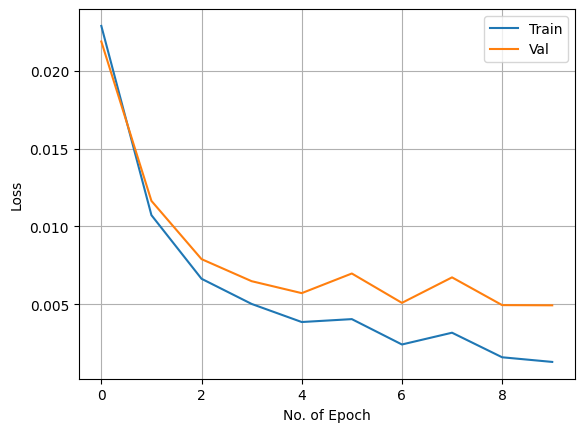

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(len(loss_metric['train_loss']))]
plt.plot(x,loss_metric['train_loss'])
plt.plot(x,loss_metric['val_loss'])
plt.legend(['Train','Val'])
plt.xlabel('No. of Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## Checking performance for the NER task..!

In [ ]:
def compare_dicts(result_dict, output_dict):
    comparison = {}
    for key in output_dict.keys():
        expected = output_dict[key]
        predicted = result_dict.get(key, None)

        # Normalize string values
        if isinstance(expected, str) and isinstance(predicted, str):
            expected = expected.strip().lower()
            predicted = predicted.strip().lower()

        # For lists: compare ignoring order
        if isinstance(expected, list) and isinstance(predicted, list):
            correct = sorted(expected) == sorted(predicted)
        else:
            correct = expected == predicted

        comparison[key] = {
            "expected": output_dict[key],
            "predicted": result_dict.get(key, None),
            "match": correct
        }

    return comparison

def dict_accuracy(result_dict, output_dict):
    comp = compare_dicts(result_dict, output_dict)
    matches = sum(1 for k in comp if comp[k]['match'])
    acc = {key: int(comp[key]["match"]) for key in comp}
    return acc



In [ ]:
def run_generation(model, tokenizer, example):
    model.eval()
    prompt = prepare_test_prompt(example)
    # print(prompt)

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_length = inputs["input_ids"].shape[-1]

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=512,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    # Get generated text *excluding* the input
    generated_ids = output_ids[:, input_length:]
    decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    try:
        result_dict = ast.literal_eval(decoded.strip())
    except Exception as e:
        result_dict = {"error": str(e), "raw_output": decoded}

    return result_dict


In [ ]:
example = ds_train[1]
predicted_dict = run_generation(peft_model, tokenizer, example)

print("Predicted:", predicted_dict)
print("Actual:", example["output"])


Predicted: {'action': 'Cycling', 'date': '20/03/2024', 'time': '6:00 AM', 'attendees': ['Luke'], 'location': 'Riverside Park', 'duration': '45 mins', 'recurrence': None, 'notes': None}
Actual: {'action': 'Cycling', 'date': '20/03/2024', 'time': '6:00 AM', 'attendees': ['Luke'], 'location': 'Riverside Park', 'duration': '45 mins', 'recurrence': None, 'notes': None}


### Saving the model and tokenizer..!

In [ ]:
peft_model.save_pretrained("lora-ner-model")
tokenizer.save_pretrained("lora-ner-model")

!tar -zcvf lora-ner-model.tar.gz /kaggle/working/lora-ner-model

tar: Removing leading `/' from member names
/kaggle/working/lora-ner-model/
/kaggle/working/lora-ner-model/adapter_config.json
/kaggle/working/lora-ner-model/special_tokens_map.json
/kaggle/working/lora-ner-model/adapter_model.safetensors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/kaggle/working/lora-ner-model/tokenizer_config.json
/kaggle/working/lora-ner-model/merges.txt
/kaggle/working/lora-ner-model/vocab.json
/kaggle/working/lora-ner-model/README.md
/kaggle/working/lora-ner-model/tokenizer.json


### Calculating accuracy for NER task..!

In [ ]:
import pandas as pd

comp = ast.literal_eval(ds_train[0]['output']).keys()

result_df = {}
for i in tqdm(range(ds_train.__len__())):
    example = ds_train[i]
    predicted_dict = run_generation(peft_model, tokenizer, example)
    example['output'] = ast.literal_eval(example['output'])
    matches = dict_accuracy(predicted_dict,example['output'])

    for com in comp:
        if com in result_df.keys():
            result_df[com].append(matches[com])
        else:
            result_df[com]=[]
            result_df[com].append(matches[com])


100%|██████████| 712/712 [1:12:56<00:00,  6.15s/it]


In [ ]:
result_df = pd.DataFrame(result_df)
print("Average accuracy for each `NER` on training set..!")
print("\n")
print(result_df.describe().loc['mean'])
result_df.to_csv('Train_Error.csv')

Average accuracy for each `NER` on training set..!


action        0.978933
date          0.987360
time          0.994382
attendees     0.994382
location      0.991573
duration      0.985955
recurrence    0.997191
notes         0.983146
Name: mean, dtype: float64


In [ ]:
comp = ast.literal_eval(ds_train[0]['output']).keys()

result_df = {}
for i in tqdm(range(ds_val.__len__())):
    example = ds_val[i]
    predicted_dict = run_generation(peft_model, tokenizer, example)
    # example['output'] = ast.literal_eval(example['output'])
    matches = dict_accuracy(predicted_dict,example['output'])

    for com in comp:
        if com in result_df.keys():
            result_df[com].append(matches[com])
        else:
            result_df[com]=[]
            result_df[com].append(matches[com])

100%|██████████| 80/80 [08:04<00:00,  6.05s/it]


In [ ]:
result_df = pd.DataFrame(result_df)
print("Average accuracy for each `NER` on validation set..!")
print("\n")
print(result_df.describe().loc['mean'])
result_df.to_csv('Val_Error.csv')

Average accuracy for each `NER` on validation set..!


action        0.8875
date          0.9625
time          0.9875
attendees     0.9875
location      0.9500
duration      0.9750
recurrence    1.0000
notes         0.9375
Name: mean, dtype: float64


-------------